Figures first, explanations later!

<img src="http://tbenthompson.com/qd_1d.png" alt="Evolution of a quasidynamic spring-block-slider system."/>

Recently, I've been working on some 3D quasidynamic earthquake modeling problems. We're planning to add in some realistic geometries using tectosaur to see what influence that has on the earthquake cycle. While putting together that 3D model, I realized that it consists of two main pieces:

* The numerical methods for determining traction on the fault surface given the current values of slip everywhere on the fault (elasticity!)
* The frictional evolution for determining the current velocity on the fault surface from the traction.

Or, in pseudocode, it's a simple feedback where I loop: 
```
while not done:
    slip += velocity * dt
    traction = elastic_solver(slip)
    velocity = rate_state_solver(traction)
```

I've been working on the `elastic_solver` part for several years (and applying it to a bunch of cool quasistatic problems!) and am quite confident that it's producing the right results. So, when I was running into strange behavior and crazy results, I figured the problems must be in the `rate_state_solver`. 

And the `rate_state_solver` is actually almost identical in both the 3D problem and a 1D spring block slider problem. So, I set out to repeat the same little exercise that has probably been done a thousand times before. 

If you want a much better designed rate-state friction solver, check out [John Leeman's rsfmodel package](https://github.com/jrleeman/rsfmodel).

In [1]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import ode, odeint
import matplotlib.pyplot as plt

First, some reasonably typical material property parameters.

In [2]:
sm = 3e10                  # Shear modulus (Pa)
density = 2700             # rock density (kg/m^3)
cs = np.sqrt(sm / density) # Shear wave speed (m/s)
eta = sm / (2 * cs)        # The radiation damping coefficient (kg / (m^2 * s))
L = 60 * 1000              # Width of our plate boundary (m)
k = sm / L                 # spring constant (Pa / m)
Vp = 1e-9                  # Rate of plate motion

Next, the regularized rate and state friction law with the aging law, and some simple parameter choices that lead to cyclic earthquake behavior. I'm mixing together a few different sources here, but the main ones are:

* Erickson and Dunham, *An efficient numerical method for earthquake cycles in heterogeneous media: Alternating sub-basin and surface-rupturing events on faults crossing a sedimentary basin, 2014.*
* Segall, *Earthquake and Volcano Deformation.*

In [3]:
sigma_n = 50e6   # Normal stress (Pa)
a = 0.015        # direct velocity strengthening effect
b = 0.02         # state-based velocity weakening effect
Dc = 0.2         # state evolution length scale (m)
f0 = 0.6         # baseline coefficient of friction
V0 = 1e-6        # when V = V0, f = f0, V is (m/s)

# Rate-state friction law w/ Rice et al 2001 regularization so that 
# it is nonsingular at V = 0
def F(V, sigma_n, state):
    f = a * np.arcsinh(V / (2 * V0) * np.exp(state / a))
    # the frictional stress is equal to the friction coefficient * the normal stress.
    return f * sigma_n

# State evolution law -- aging law.
def G(V, state):
    return (b * V0 / Dc) * (np.exp((f0 - state) / b) - (V / V0))

I'll check $k_{crit}$. If $k > k_{crit}$, the system is unconditionally unstable and $V \to \infty$.

In [4]:
kcrit = sigma_n * b / Dc 
print('k/kcrit =', k / kcrit)

k/kcrit = 0.1


Great! 

Next, I'll set up the initial conditions for the model:

In [5]:
x_0 = 0.0 # slider position
V_slider_0 = Vp / 1000.0 # Initially, the slider is moving at 1/1000th the plate rate.

Setting the initial condition for the state variable is non-trivial because I don't want crazy swings at the beginning of the model. So, I solve for the steady-state state variable given the initial velocity. Since $\frac{\partial state}{\partial t}$ `= G(V, state)`, that just involves solving for the value of `state` at which `G(V, state) = 0`. I use the `fsolve` scipy function. (Did you notice that equation that was partially Latex and partially code? It felt weird typing that.)

In [6]:
def steady_state(V_slider):
    def f(state):
        return G(V_slider, state)
    return fsolve(f, 0.0)[0]
state_0 = steady_state(V_slider_0)

Okay, so now I'm getting to the part where I actually solve the differential equations! But, first, there's an interesting thing about this model. It's actually a differential algebraic equation (DAE) instead of a pure ODE. That's because the current velocity is not defined in differential terms, but instead it is implicity defined as a function of the current shear stress and state parameter. Most of the time, for the 1D spring block slider model that I'm looking at here, folks have transformed it into a pure ODE. However, that transformation to an ODE doesn't work very well in the 3D setting. So, for 3D, I'm stuck with a DAE. It's not as easy, but it's also not **that** bad. For the sake of easily translating the 1D model here to use a 3D elastic solver, I'm going to actually keep using the DAE formulation.

So, at each time step, I need to solve an algebraic equation for the current velocity. 

$ \tau_{qs} - F(V, \sigma_n, state) = \eta V$

Aside: This is actually a transformed version of the typical momentum equation $F = ma$, where $ma$ is replaced by the "quasidynamic" approximation, $\eta V$ and $F$ is replaced by the driving shear force $\tau_{qs}$ and the resisting friction force $F(V, \sigma_n, state)$

As an implementation detail, I warm-start the `fsolve` call with `V_slider_old`, which is the velocity from the previous time step - a decent guess for the new velocity.

In [7]:
def current_vel(tau_qs, state, V_slider_old):
    def f(V):
        return tau_qs - eta * V - F(V, sigma_n, state)
    return fsolve(f, V_slider_old)[0]

When using `odeint`, I need to define the points in time where I want to observe the state of the system. So, every year, for 15,000 years. (This is not the size of the time step, which is internally decided by `odeint`).

In [8]:
secs_per_year = 365 * 24 * 60 * 60
h_t_yrs = np.linspace(0.0, 15000.0, 15001)
h_t = h_t_yrs * secs_per_year

Next, I define the derivatives. 

In [9]:
def f(x_and_state, t):
    x, state = x_and_state
    # The position of the load point.
    y = Vp * t 
    
    # The extensional force of our spring 
    tau_qs = k * (y - x) 
    
    # Solve for the current velocity
    V_slider = current_vel(tau_qs, state, f.V_slider_old) 
    
    # Store the velocity to use it next time for warm-start the velocity solver
    f.V_slider_old = V_slider 
    
    dxdt = V_slider
    dstatedt = G(V_slider, state)
    return [dxdt, dstatedt]
f.V_slider_old = V_slider_0

Define the initial conditions:

In [10]:
initial_conditions = np.array([x_0, state_0])

And actually solve the equations!

In [11]:
history = odeint(f, initial_conditions, h_t, rtol=1e-12, atol=1e-12, mxstep=5000)

In [12]:
h_x = history[:,0]
h_state = history[:,1]
h_V = (h_x[1:] - h_x[:-1]) / (h_t[1:] - h_t[:-1])
h_y = h_t * Vp
h_tau_qs = k * (h_y - h_x)
h_tau_qd = h_tau_qs[1:] - eta * h_V

Finally, I'll plot up the results.

In [13]:
#plt.style.use('dark_background')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['text.latex.preamble'] = '\\usepackage{amsmath}'
plt.rcParams['savefig.transparent'] = False

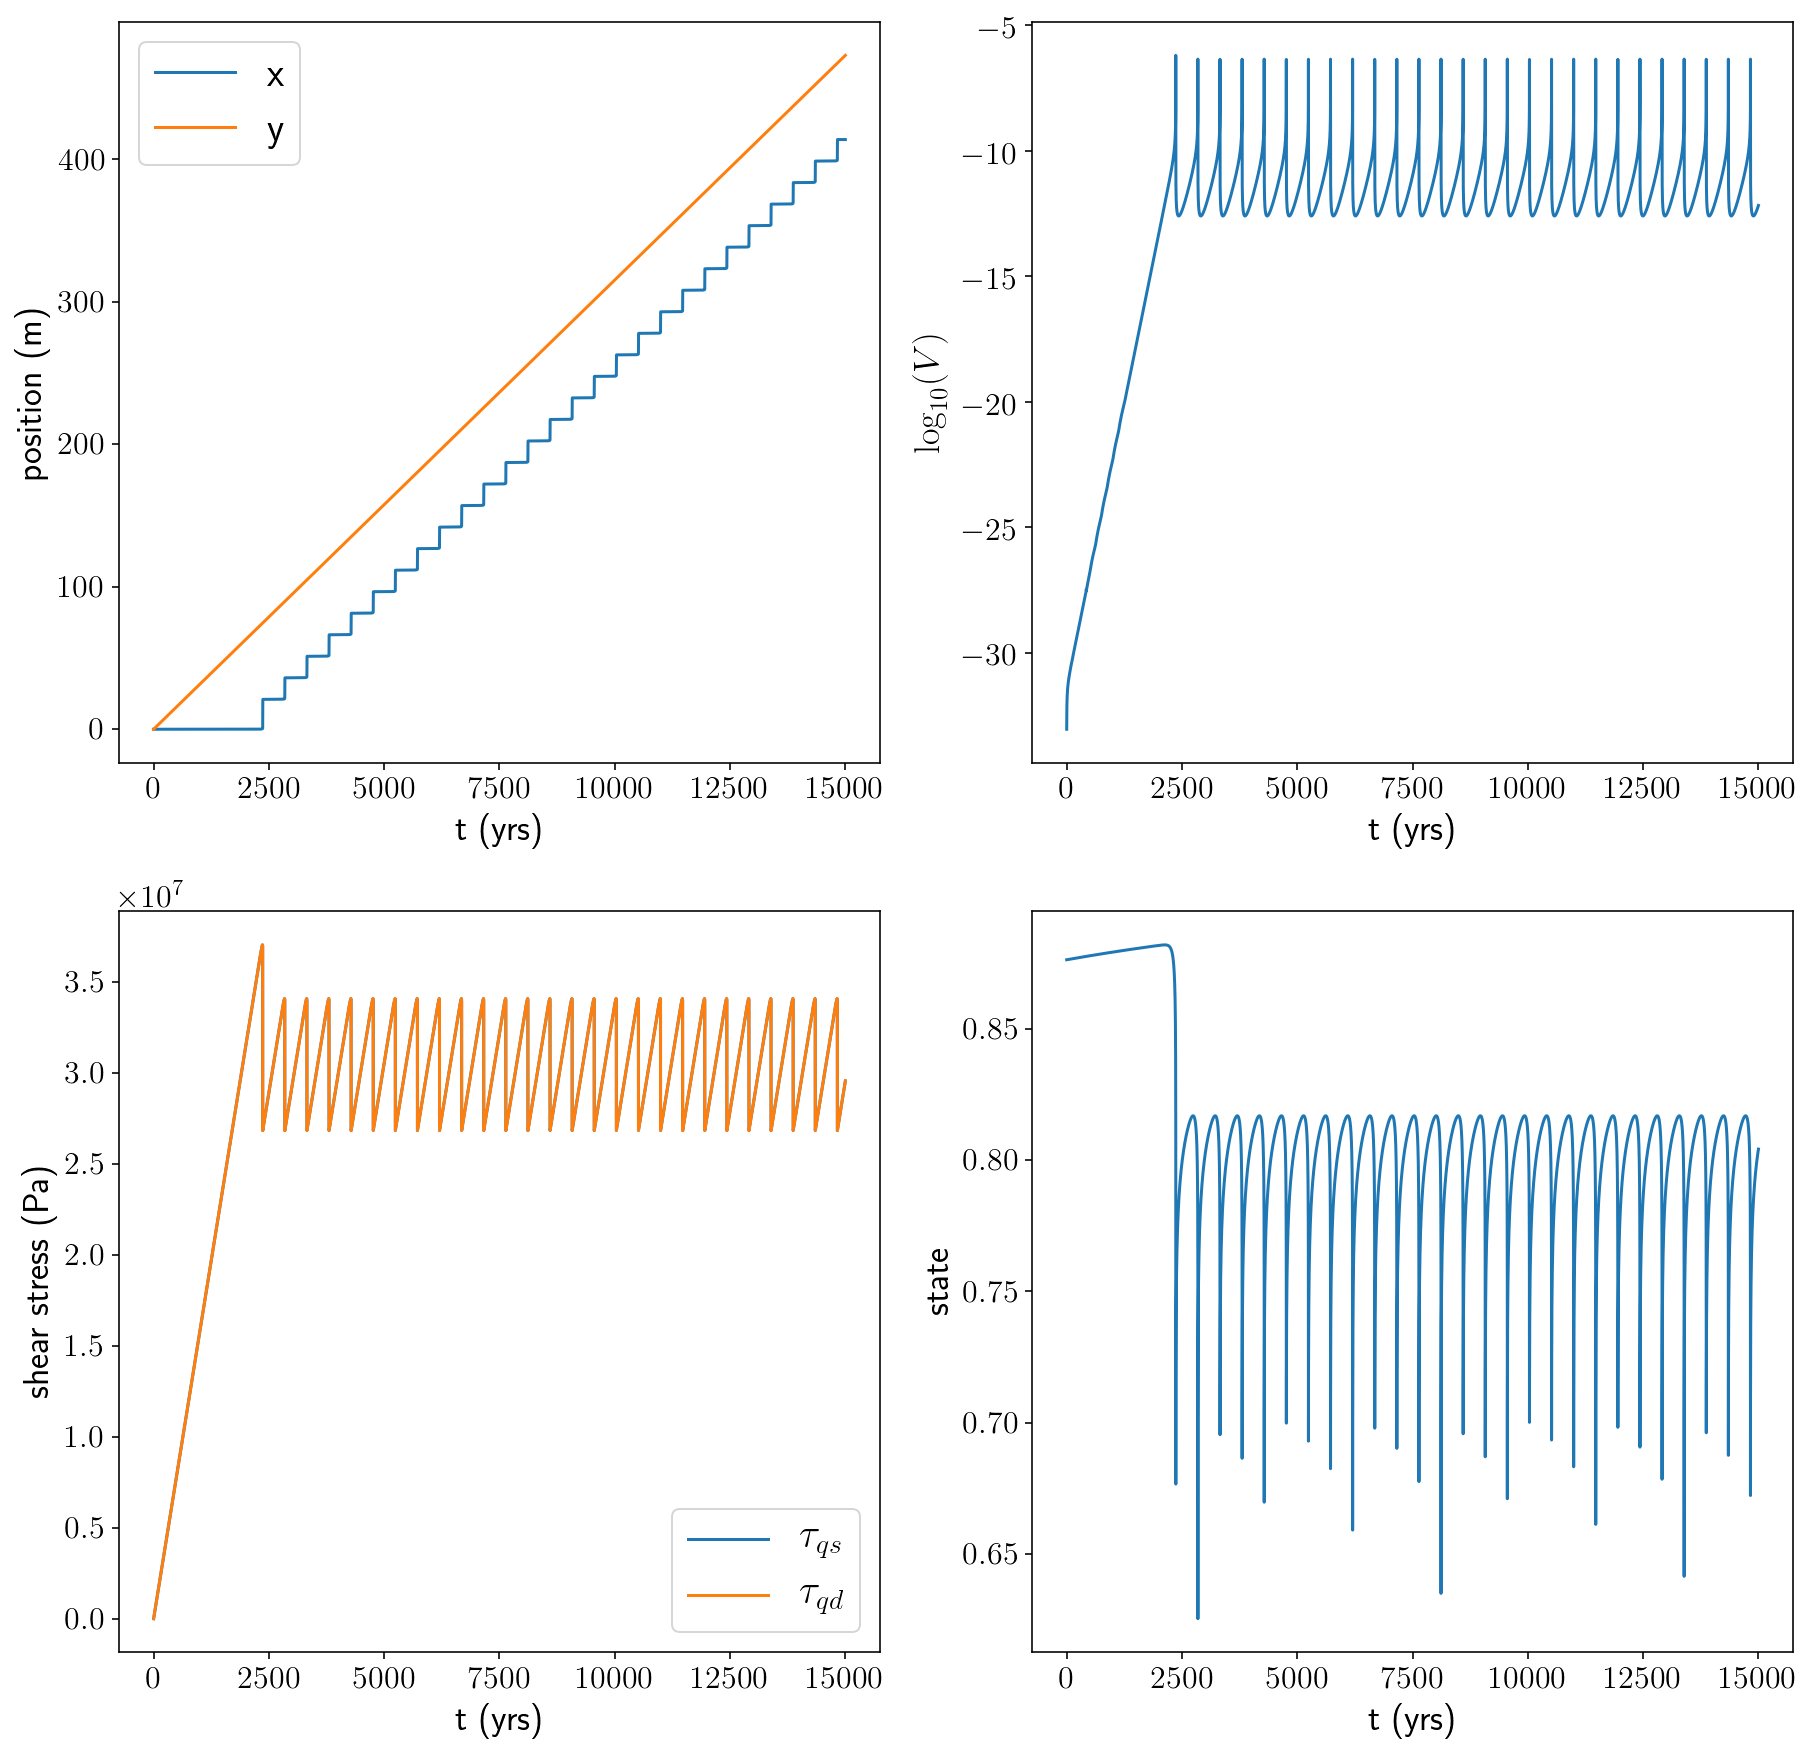

In [14]:
plt.figure(figsize = (15, 15))
ax11 = plt.subplot(221)
plt.plot(h_t_yrs, h_x, label = 'x')
plt.plot(h_t_yrs, h_y, label = 'y')
plt.xlabel('t (yrs)')
plt.ylabel('position (m)')
plt.legend()
ax12 = plt.subplot(222)
plt.plot(h_t_yrs[1:], np.log10(h_V))
plt.xlabel('t (yrs)')
plt.ylabel('$\\log_{10}(V)$')
plt.subplot(223, sharex = ax11)
plt.plot(h_t_yrs, h_tau_qs, label = '$\\tau_{qs}$')
plt.plot(h_t_yrs[1:], h_tau_qd, label = '$\\tau_{qd}$')
plt.xlabel('t (yrs)')
plt.ylabel('shear stress (Pa)')
plt.legend()
plt.subplot(224)
plt.plot(h_t_yrs, h_state)
plt.xlabel('t (yrs)')
plt.ylabel('state')
plt.savefig('qd_1d.pdf', bbox_inches = 'tight')
plt.savefig('qd_1d.png', bbox_inches = 'tight', dpi = 200)
plt.show()